In [2]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data =  pd.read_csv("salesdaily.csv")
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


# Seasonality analysis

The seasonality patterns can be explored in detail by using boxplots. Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.

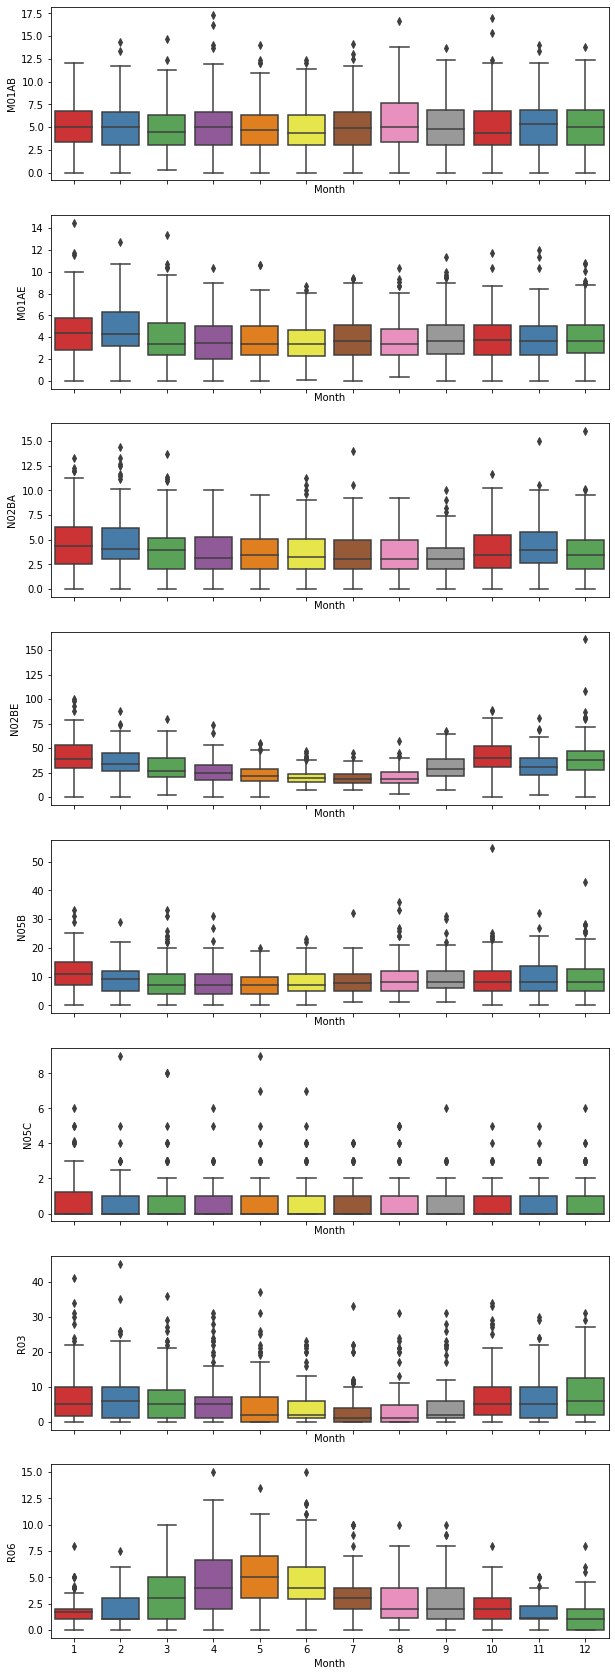

In [ ]:
import seaborn as sns
dfatc_daily = data
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month',palette='Set1' ,y=name, ax=ax)
    

Below, boxplots on a weekly scale are shown, for the purpose of exploring the weakly seasonality. Some weekly seasonality is visible.

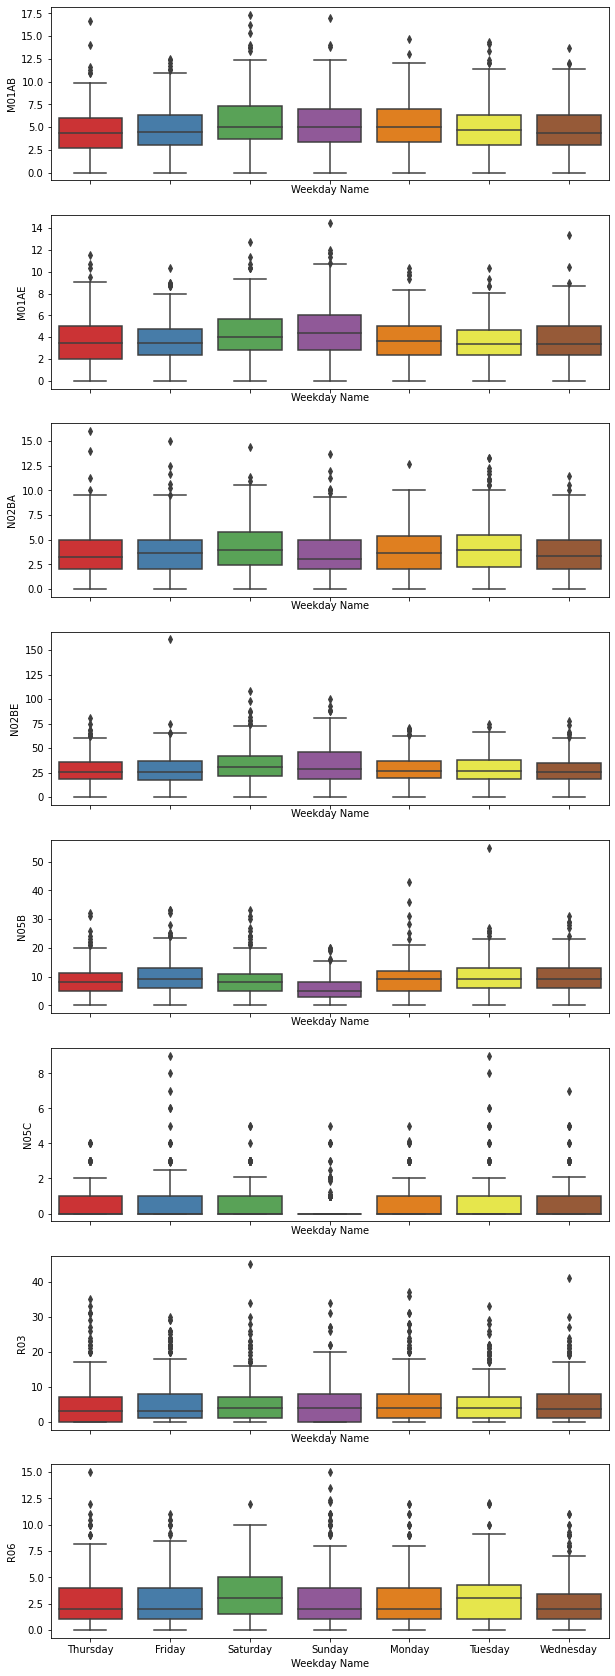

In [ ]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, palette='Set1',ax=ax)

Another visualization that can be useful for discovering seasonality patterns is related to rolling window means. Rolling window operations are another important transformation for time series data.

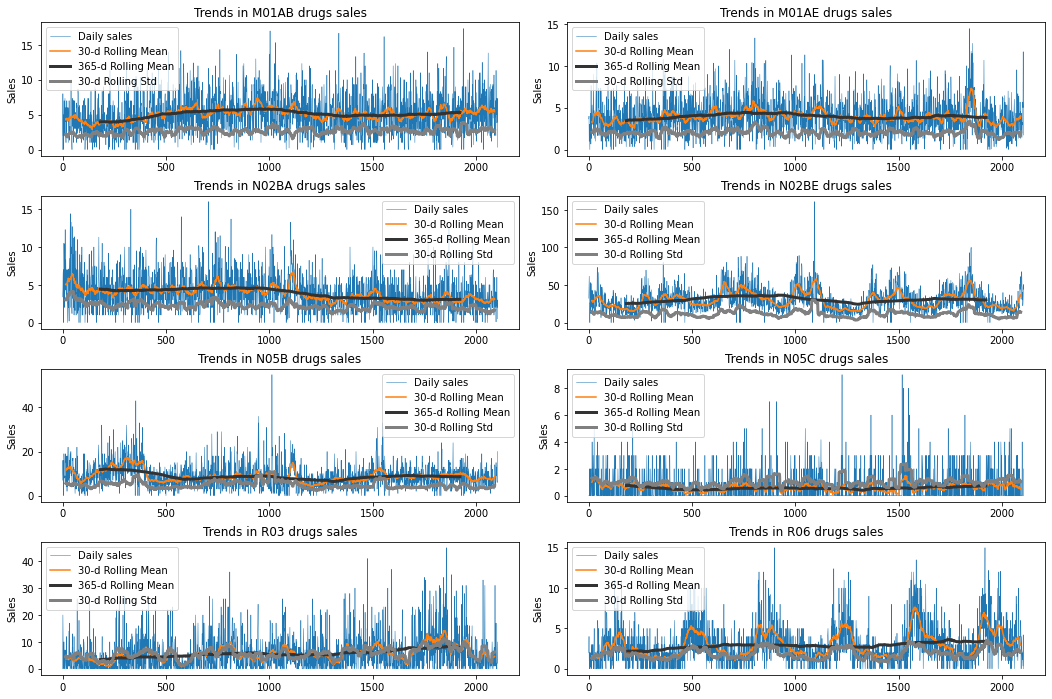

In [ ]:
dfatc_daily=data
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

Image below shows trends for each of the drug categories, represented by the 365-d rolling means for each of those categories.

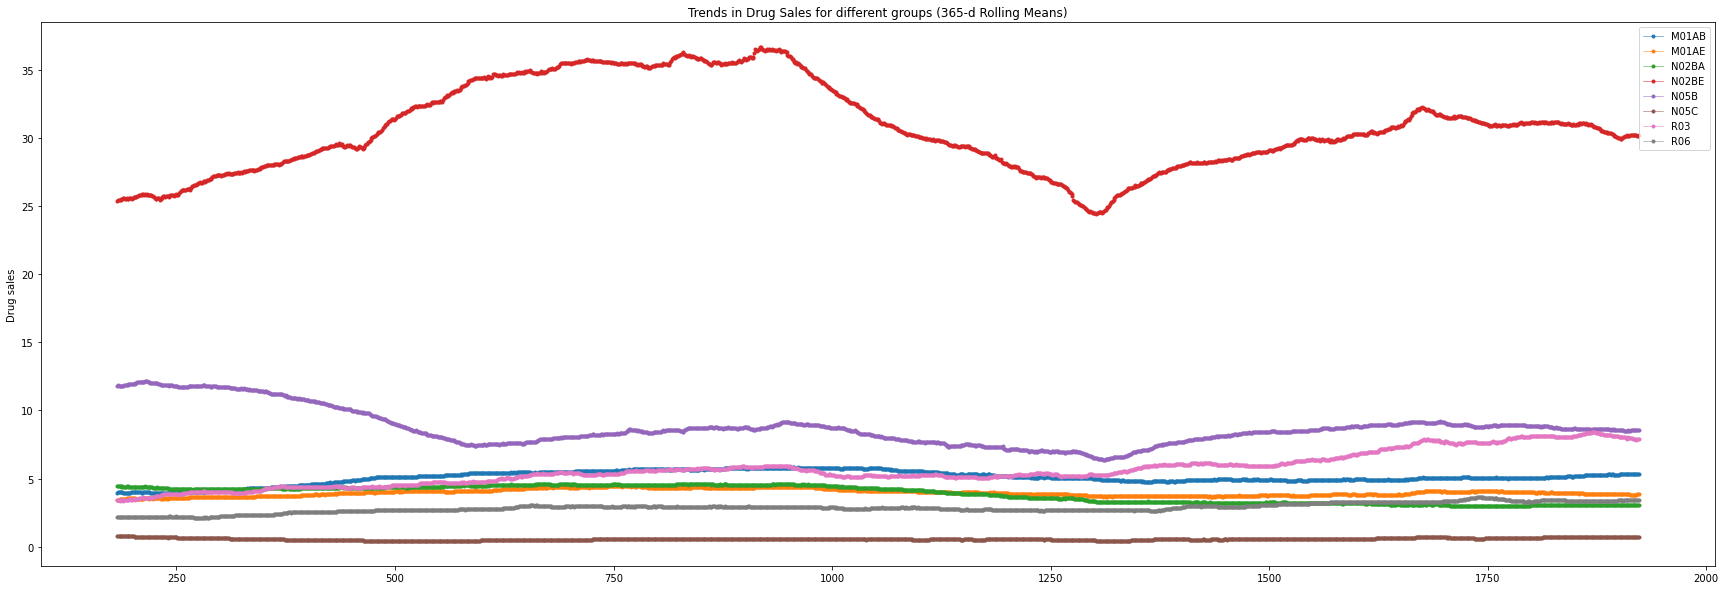

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
df = data
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], freq=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:2.0712636400118356, OBSMEAN:5.034424091204479, PERC:41.142017487769664%
M01AE RESMEAN:1.590095743692594, OBSMEAN:3.9018980748943526, PERC:40.751852384961325%
N02BA RESMEAN:1.732234207835713, OBSMEAN:3.8720589094454723, PERC:44.73677307982359%
N02BE RESMEAN:8.775463248355404, OBSMEAN:29.80099937114898, PERC:29.446875720722065%
N05B RESMEAN:3.821099567543921, OBSMEAN:8.82294912364703, PERC:43.308643334491336%
N05C RESMEAN:0.7529943650481807, OBSMEAN:0.5910215839011684, PERC:127.40556107576904%
R03 RESMEAN:4.279737895727971, OBSMEAN:5.5430410175292115, PERC:77.2092048785821%
R06 RESMEAN:1.4681486636933785, OBSMEAN:2.916449610516066, PERC:50.3402718977061%


Trends and seasonality can be explored in time series decomposition view, based on 30d rolling means.

Function seasonal_decompose can be used for analysis of the portions of each component of time series. This is especially useful when determining uptake of residuals in data, based on the decomposed data. 

In [ ]:
df = data
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], freq=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:2.0712636400118356, OBSMEAN:5.034424091204479, PERC:41.142017487769664%
M01AE RESMEAN:1.590095743692594, OBSMEAN:3.9018980748943526, PERC:40.751852384961325%
N02BA RESMEAN:1.732234207835713, OBSMEAN:3.8720589094454723, PERC:44.73677307982359%
N02BE RESMEAN:8.775463248355404, OBSMEAN:29.80099937114898, PERC:29.446875720722065%
N05B RESMEAN:3.821099567543921, OBSMEAN:8.82294912364703, PERC:43.308643334491336%
N05C RESMEAN:0.7529943650481807, OBSMEAN:0.5910215839011684, PERC:127.40556107576904%
R03 RESMEAN:4.279737895727971, OBSMEAN:5.5430410175292115, PERC:77.2092048785821%
R06 RESMEAN:1.4681486636933785, OBSMEAN:2.916449610516066, PERC:50.3402718977061%


# Stationarity analysis

Stationarity of time-series is the property of exhibiting constant statistical properties over time (for example, mean, variance, autocorrelation). It can be visually determined by plotting rolling statistics (rolling means and variances). In stationary time series, the mean of the series, variance of the series and covariance of the i th term and the (i + m) th term should not be a function of time.

In [ ]:
df= data
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -8.669
P-value = 0.000
Critical values :
	1%: -3.9631060717799924 - The data is  stationary with 99% confidence
	5%: -3.41259173685078 - The data is  stationary with 95% confidence
	10%: -3.1282874376905356 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -7.471
P-value = 0.000
Critical values :
	1%: -3.9631206583322434 - The data is  stationary with 99% confidence
	5%: -3.4125988034261017 - The data is  stationary with 95% confidence
	10%: -3.128291597193074 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -7.829
P-value = 0.000
Critical values :
	1%: -3.9631123111656277 - The data is  stationary with 99% confidence
	5%: -3.412594759575526 - The data is  stationary with 95% confidence
	10%: -3.1282892169169547 - The data is  stationary with 90% confidence
ADF test for N02BE
----------------------

Augmented Dickey-Fuller (ADF) test have shown that all data, but N02BA (P-value=0.249) in the series were stationary, with maximum confidence.

In [ ]:
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore")
df=data
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    print(" > Is "+x+" data stationary ?")
    dftest = kpss(np.log(df[x]), 'ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[3].items():
        print("\t{}: {}".format(k, v))

 > Is M01AB data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is M01AE data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BA data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BE data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05B data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05C data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R03 data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R06 data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	

# Regularity analysis

For calculating regularity and predictability of time series, Approximate Entropy test was used.

In [ ]:
df = data    
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.9240540330273106
M01AE: 1.857327473757116
N02BA: 1.892642953919645
N02BE: 1.6799337801661745
N05B: 1.6861129738301162
N05C: 0.9828634612700058
R03: 1.5583141792099964
R06: 1.7019103198024172


# Autocorrelation analysis

Autocorrelation analysis illustrates the potential for time series data prediction. Autocorrelation plots graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. Pearson coefficient is used to measure autocorrelation. Thus, the following analysis is relevant only for data with normal Gaussian distribution.

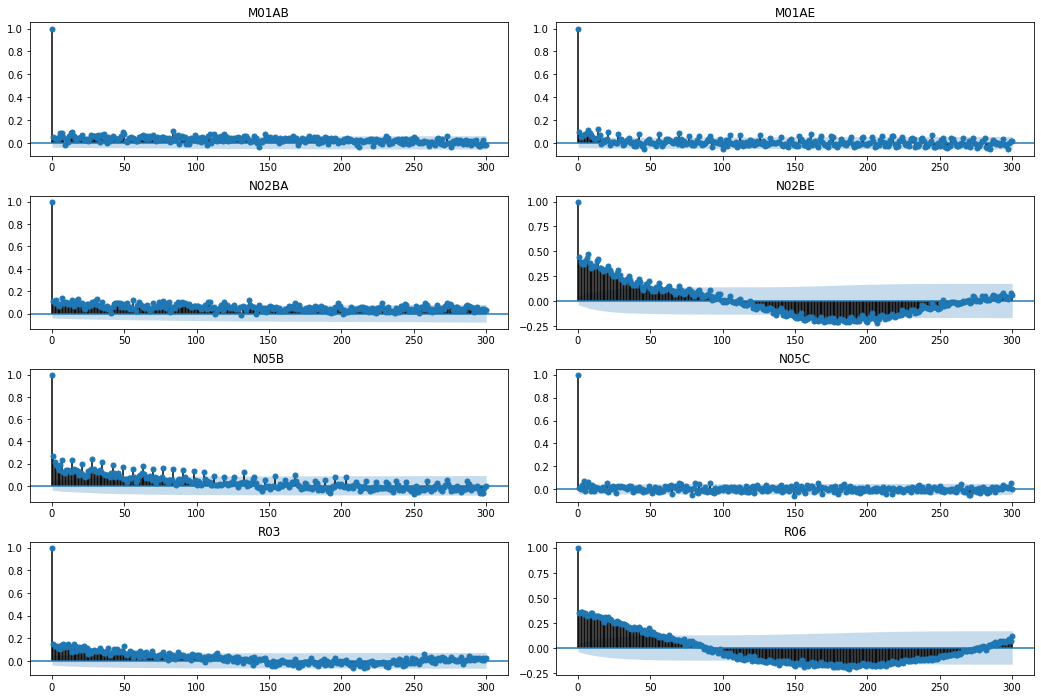

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables.

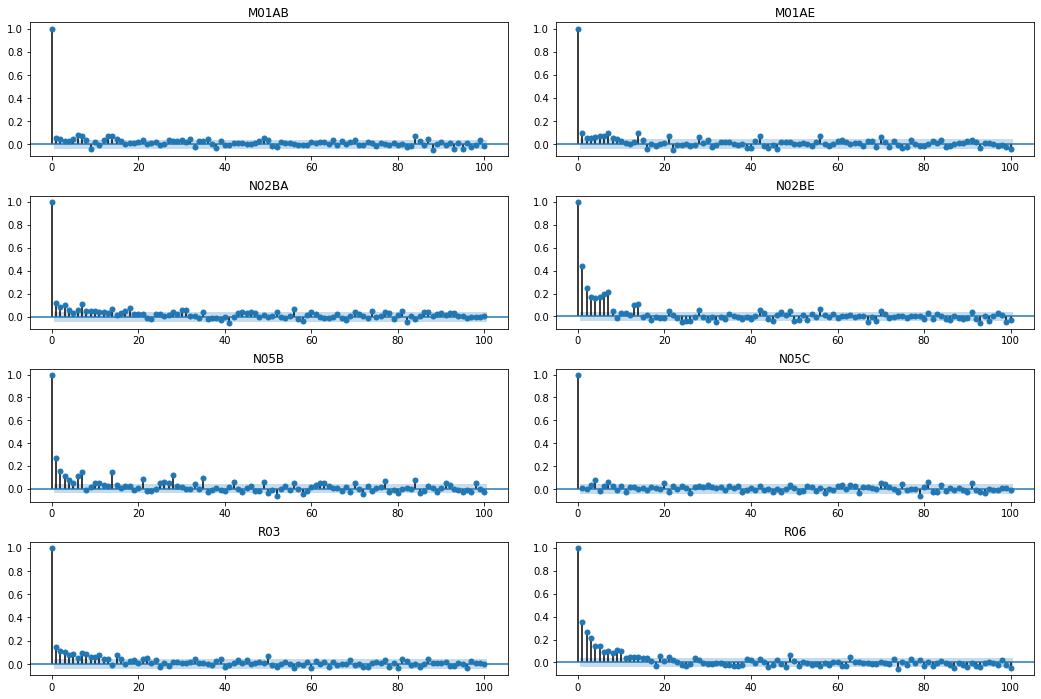

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

# Data distribution analysis

Chart with daily sales for different categories of interest is shown below.

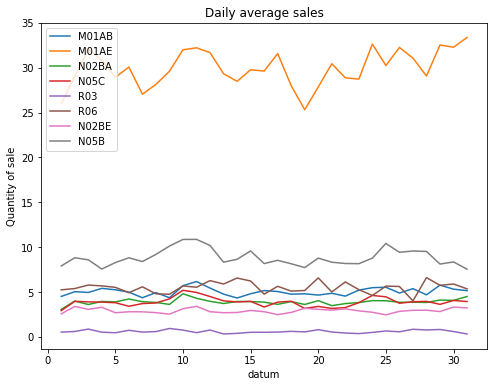

In [ ]:
dfatch= data
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.day)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.day)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.day)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.day)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.day)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.day)['R06'].mean()
grp4=dfatch.groupby(dfatch.datum.dt.day)['N02BE'].mean()
grp5=dfatch.groupby(dfatch.datum.dt.day)['N05B'].mean()

plt.title('Daily average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp4.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))
grp5.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06', "N02BE", "N05B"], loc='upper left')

plt.show()

# **Autoregression**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(2106, 12)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

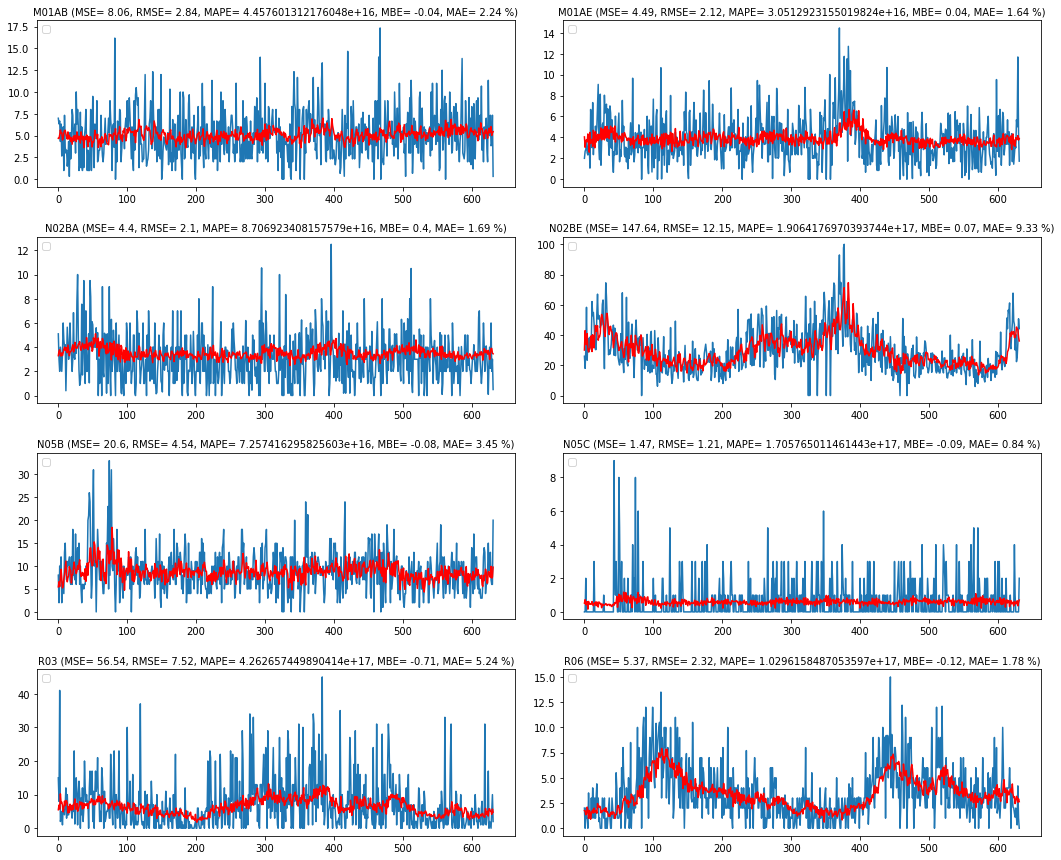

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  train, test = data2[0:int(len(data2)*0.7)], data2[int(len(data2)*0.7):]
  train = train[j].values
  test = test[j].values
  
  # train autoregression
  window = 29
  model = AutoReg(train, lags=29)
  model_fit = model.fit()
  coef = model_fit.params
  # walk forward over time steps in test
  history = train[len(train)-window:]
  history = [history[i] for i in range(len(history))]
  predictions = list()
  for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window , length)]
    yhat = coef[0]
    for d in range(window):
      yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
 
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions - test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **ARIMA**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(2106, 12)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

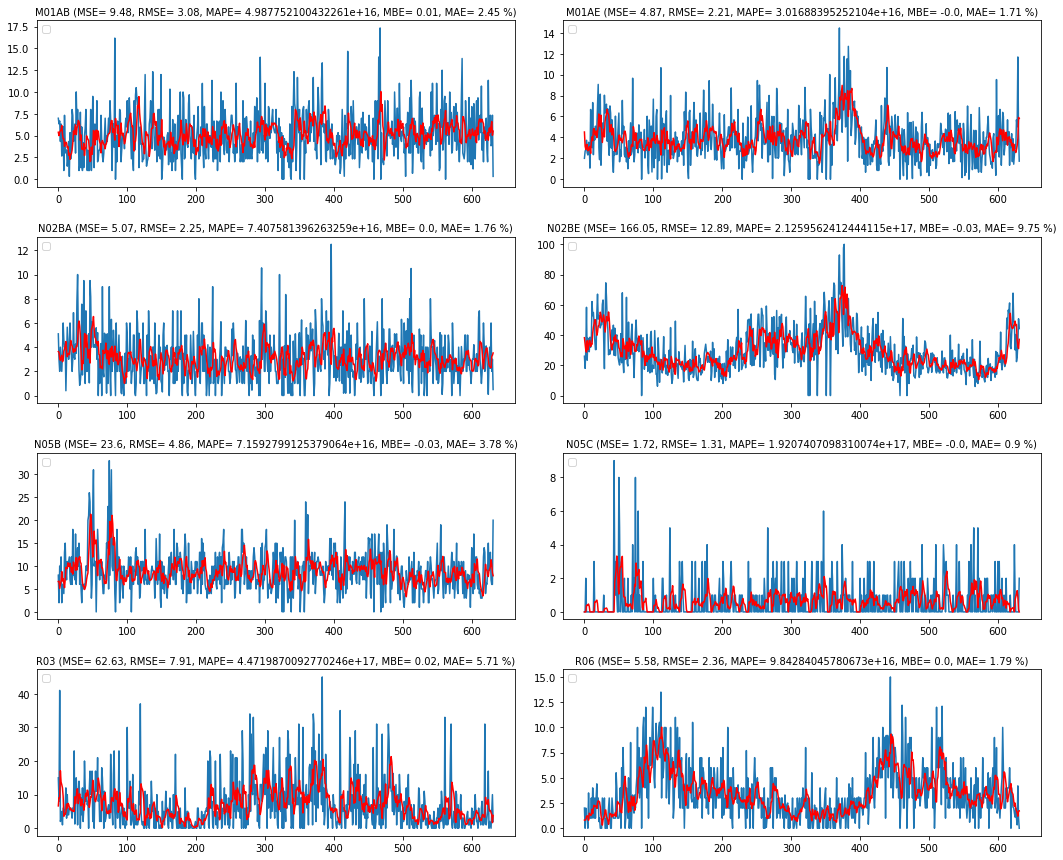

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  
  train_data, test_data = data2[0:int(len(data2)*0.7)], data2[int(len(data2)*0.7):]
  training_data = train_data[j].values
  test_data = test_data[j].values
  history = [x for x in training_data]
  model_predictions = []
  N_test_observations = len(test_data)
  for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
  MSE_error = mean_squared_error(test_data, model_predictions)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(test_data, model_predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(test_data, model_predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(model_predictions - test_data),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(test_data, model_predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(test_data)
  ax[rowindex,colindex].plot(model_predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

In [ ]:
mse

[9.48, 4.87, 5.07, 166.05, 23.6, 1.72, 62.63, 5.58]

In [ ]:
mape

[4.987752100432261e+16,
 3.01688395252104e+16,
 7.407581396263259e+16,
 2.1259562412444115e+17,
 7.1592799125379064e+16,
 1.9207407098310074e+17,
 4.4719870092770246e+17,
 9.84284045780673e+16]

In [ ]:
rmse

[3.08, 2.21, 2.25, 12.89, 4.86, 1.31, 7.91, 2.36]

In [ ]:
mae

[2.45, 1.71, 1.76, 9.75, 3.78, 0.9, 5.71, 1.79]

In [ ]:
mbe

[0.01, -0.0, 0.0, -0.03, -0.03, -0.0, 0.02, 0.0]